# S&P 500 Transformer Model

This notebook trains a transformer model using data from multiple stocks.

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from numerical_preprocessing import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

tf.random.set_seed(1234)

Check if GPU is available

In [3]:
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available: 1


In [4]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

### Import Dataset

In [5]:
data = pd.read_csv("stock_yfinance_data.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


### Preprocess Stocks

In [6]:
train_x, train_y, test_x, test_y = preprocess_stock_data(data)
train_x.shape

(4525, 20, 13)

### Define Model

In [7]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, num_heads=4, dropout_rate=0.1):
        super(TransformerModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_heads = num_heads

        # Transformer Encoder Layers
        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim) 
            for _ in range(num_layers)
        ]

        self.norm_layers = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6) 
            for _ in range(num_layers)
        ]

        self.dropout_layers = [
            tf.keras.layers.Dropout(dropout_rate) 
            for _ in range(num_layers)
        ]

        # Fully Connected Layers for Prediction
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense1 = tf.keras.layers.Dense(hidden_dim // 2, activation="relu")
        self.dense2 = tf.keras.layers.Dense(output_size)

    def call(self, x):
        # Apply Transformer Encoder Layers
        for i in range(self.num_layers):
            attn_output = self.encoder_layers[i](x, x)  # Self-attention
            x = self.norm_layers[i](x + attn_output)  # Add & Normalize
            x = self.dropout_layers[i](x)

        # Reduce sequence dimension using Global Average Pooling
        x = self.global_avg_pool(x)

        # Fully Connected Layers
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

### Train Model

In [8]:
num_layers = 4
hidden_dim = 128
output_size = 1  # Predicting next-day stock price
num_heads = 6
dropout_rate = 0.1

model = TransformerModel(num_layers, hidden_dim, output_size, num_heads, dropout_rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    x = train_x,
    y = train_y,
    epochs=100,
    batch_size=128,
    validation_data=(test_x, test_y)
)

2025-02-24 22:24:20.243915: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-24 22:24:20.244961: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-24 22:24:20.244977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-24 22:24:20.245026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-24 22:24:20.245045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-02-24 22:24:26.984268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 785ms/step - loss: 0.0727 - mae: 0.2150 - val_loss: 0.0244 - val_mae: 0.1243
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 552ms/step - loss: 0.0335 - mae: 0.1455 - val_loss: 0.0234 - val_mae: 0.1206
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - loss: 0.0290 - mae: 0.1341 - val_loss: 0.0188 - val_mae: 0.1076
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - loss: 0.0275 - mae: 0.1302 - val_loss: 0.0189 - val_mae: 0.1073
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - loss: 0.0266 - mae: 0.1270 - val_loss: 0.0199 - val_mae: 0.1098
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - loss: 0.0259 - mae: 0.1245 - val_loss: 0.0216 - val_mae: 0.1147
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 558ms/step - loss: 0.0256 - mae: 0.1233 - val_loss: 0.0215 - val_mae: 0.1145
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - loss: 0.0251 - mae: 0.1219 - val_loss: 0.0212 - val_mae: 0.1134
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 551ms/ste

### Plot Performance

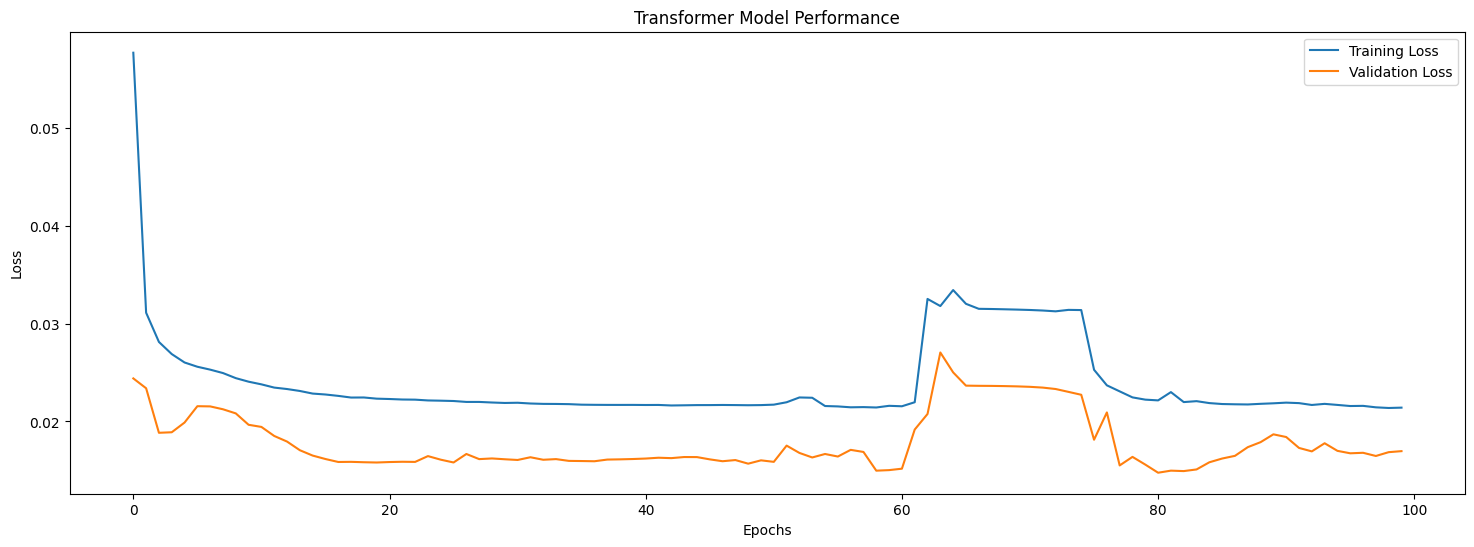

In [9]:
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("Transformer Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


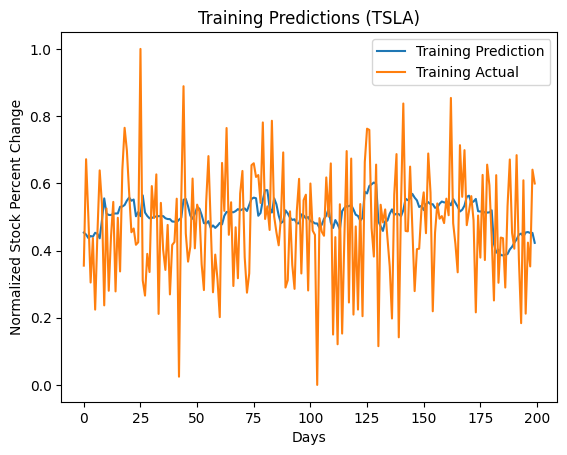

In [17]:
train_predictions = model.predict(train_x[0:200])
train_actual = train_y[0:200]
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Percent Change')
plt.title('Training Predictions (TSLA)')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


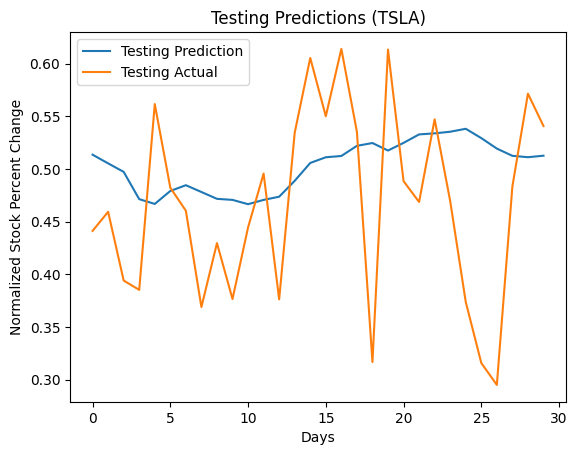

In [18]:
test_predictions = model.predict(test_x[0:30])
test_actual = test_y[0:30]
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Percent Change')
plt.title("Testing Predictions (TSLA)")
plt.legend()